**3D Classification based on DenseNet**

In [ ]:
'''
3D Classification based on DenseNet and Array format transforms
MR images classification 
'''

In [ ]:
!pip install monai
!pip install monai-weekly
!pip install ignite
!python -c "import monai; print(monai.__version__)"
!python -c "import monai" || pip install -q "monai-weekly[nibabel, ignite, pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
import os, shutil, tempfile, PIL, logging, sys
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import monai
from monai.apps import download_and_extract
from monai.data import DataLoader, ImageDataset
from monai.networks.nets import DenseNet121
from monai.config import print_config
from monai.transforms import (
    Activations, EnsureChannelFirst, AsDiscrete, Compose, RandRotate90,
    LoadImage, RandFlip, RandRotate, RandZoom, ScaleIntensity, Resize)
from monai.utils import set_determinism
print_config()

In [ ]:
''' seed/deterministic training for reproduceability '''
set_determinism(seed=0)
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!mkdir monai
os.environ['monai'] = '/content/monai'
dir = os.environ.get('monai')
rootdir = tempfile.mkdtemp() if dir is None else dir
rootdir

In [30]:
''' Download Public dataset IXI '''
resource = 'http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar'
md5 = '34901a0593b41dd19c1a1f746eac2d58'
tarfile = f'{rootdir}.tar'
download_and_extract(resource, tarfile, rootdir, md5)
''' prepare the dataset for training '''
images = [
os.sep.join([rootdir, "IXI314-IOP-0889-T1.nii.gz"]), os.sep.join([rootdir, "IXI249-Guys-1072-T1.nii.gz"]), os.sep.join([rootdir, "IXI609-HH-2600-T1.nii.gz"]), os.sep.join([rootdir, "IXI173-HH-1590-T1.nii.gz"]), os.sep.join([rootdir, "IXI020-Guys-0700-T1.nii.gz"]), os.sep.join([rootdir, "IXI342-Guys-0909-T1.nii.gz"]), os.sep.join([rootdir, "IXI134-Guys-0780-T1.nii.gz"]), os.sep.join([rootdir, "IXI577-HH-2661-T1.nii.gz"]), os.sep.join([rootdir, "IXI066-Guys-0731-T1.nii.gz"]), os.sep.join([rootdir, "IXI130-HH-1528-T1.nii.gz"]), os.sep.join([rootdir, "IXI607-Guys-1097-T1.nii.gz"]), os.sep.join([rootdir, "IXI175-HH-1570-T1.nii.gz"]), os.sep.join([rootdir, "IXI385-HH-2078-T1.nii.gz"]), os.sep.join([rootdir, "IXI344-Guys-0905-T1.nii.gz"]), os.sep.join([rootdir, "IXI409-Guys-0960-T1.nii.gz"]), os.sep.join([rootdir, "IXI584-Guys-1129-T1.nii.gz"]), os.sep.join([rootdir, "IXI253-HH-1694-T1.nii.gz"]), os.sep.join([rootdir, "IXI092-HH-1436-T1.nii.gz"]), os.sep.join([rootdir, "IXI574-IOP-1156-T1.nii.gz"]), os.sep.join([rootdir, "IXI585-Guys-1130-T1.nii.gz"]),
]
labels = np.array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])
''' Represent labels in one-hot format for binary classifier training,
BCEWithLogitsLoss requires target to have same shape as input '''
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

2025-06-29 14:46:06,906 - INFO - Verified 'monai.tar', md5: 34901a0593b41dd19c1a1f746eac2d58.
2025-06-29 14:46:06,907 - INFO - File exists: /content/monai.tar, skipped downloading.
2025-06-29 14:46:06,909 - INFO - Writing into directory: /content/monai.


In [33]:
''' Transforms and the Dataloader '''
train_transforms = Compose(
    [ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96)), RandRotate90()])
val_transforms = Compose(
    [ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory)
im, label = monai.utils.misc.first(check_loader)
train_ds = ImageDataset(
    image_files=images[:10], labels=labels[:10], transform=train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=0, pin_memory=pin_memory)
val_ds = ImageDataset(
    image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)

In [36]:
model = DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 5

In [42]:
for epoch in range(max_epochs):
  model.train()
  epoch_loss = 0 ; step = 0

  for batch_data in train_loader:
      step += 1
      inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      epoch_len = len(train_ds) // train_loader.batch_size
      #print(f'{step}/{epoch_len}, train_loss, {loss.item():.4f}')
      writer.add_scalar('train_loss', loss.item(), epoch_len*epoch + step)
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  #print(f'epoch {epoch +1} average loss: {epoch_loss:.4f}')

  if (epoch +1) % val_interval ==0:
    model.eval()
    num_correct = 0.0 ; metric_count = 0
    for val_data in val_loader:
      val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
      with torch.no_grad():
        val_outputs = model(val_images)
        value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
        metric_count += len(value)
        num_correct += value.sum().item()

    metric = num_correct / metric_count
    metric_values.append(metric)
    if metric > best_metric:
      best_metric = metric
      best_metric_epoch = epoch + 1
      torch.save(model.state_dict(), 'best_metric_model_3Dclass.pth')

    #print(f'current epoch: {epoch +1}, current accuracy {metric:.4f}')
    #print(f'best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}')
    writer.add_scalar('val accuracy', metric, epoch +1)

print(f'training complete, \
       best metric {best_metric:.4f} at epoch {best_metric_epoch}')

training complete, best metric 0.7000 at epoch 2


In [47]:
''' validation data loader '''
test_ds = ImageDataset(
    image_files=images[-10:], labels=labels[-10:], transforms=val_transforms)
test_loader = DataLoader(
    val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
iter_ = iter(test_loader)
test_data = next(iter_)
image_, label_ = test_data[0].to(device), test_data[1].unsqueeze(0).to(device)

Occlusion sensitivity

In [48]:
def occ_heatmap(image_, heatmap):
    plt.subplots(1, 2)  ; plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(image_.cpu())) ; plt.imshow(heatmap)
    plt.colorbar() ; plt.subplot(1, 2, 2) ; plt.colorbar() ; plt.show

100%|██████████| 49/49 [08:16<00:00, 10.14s/it]


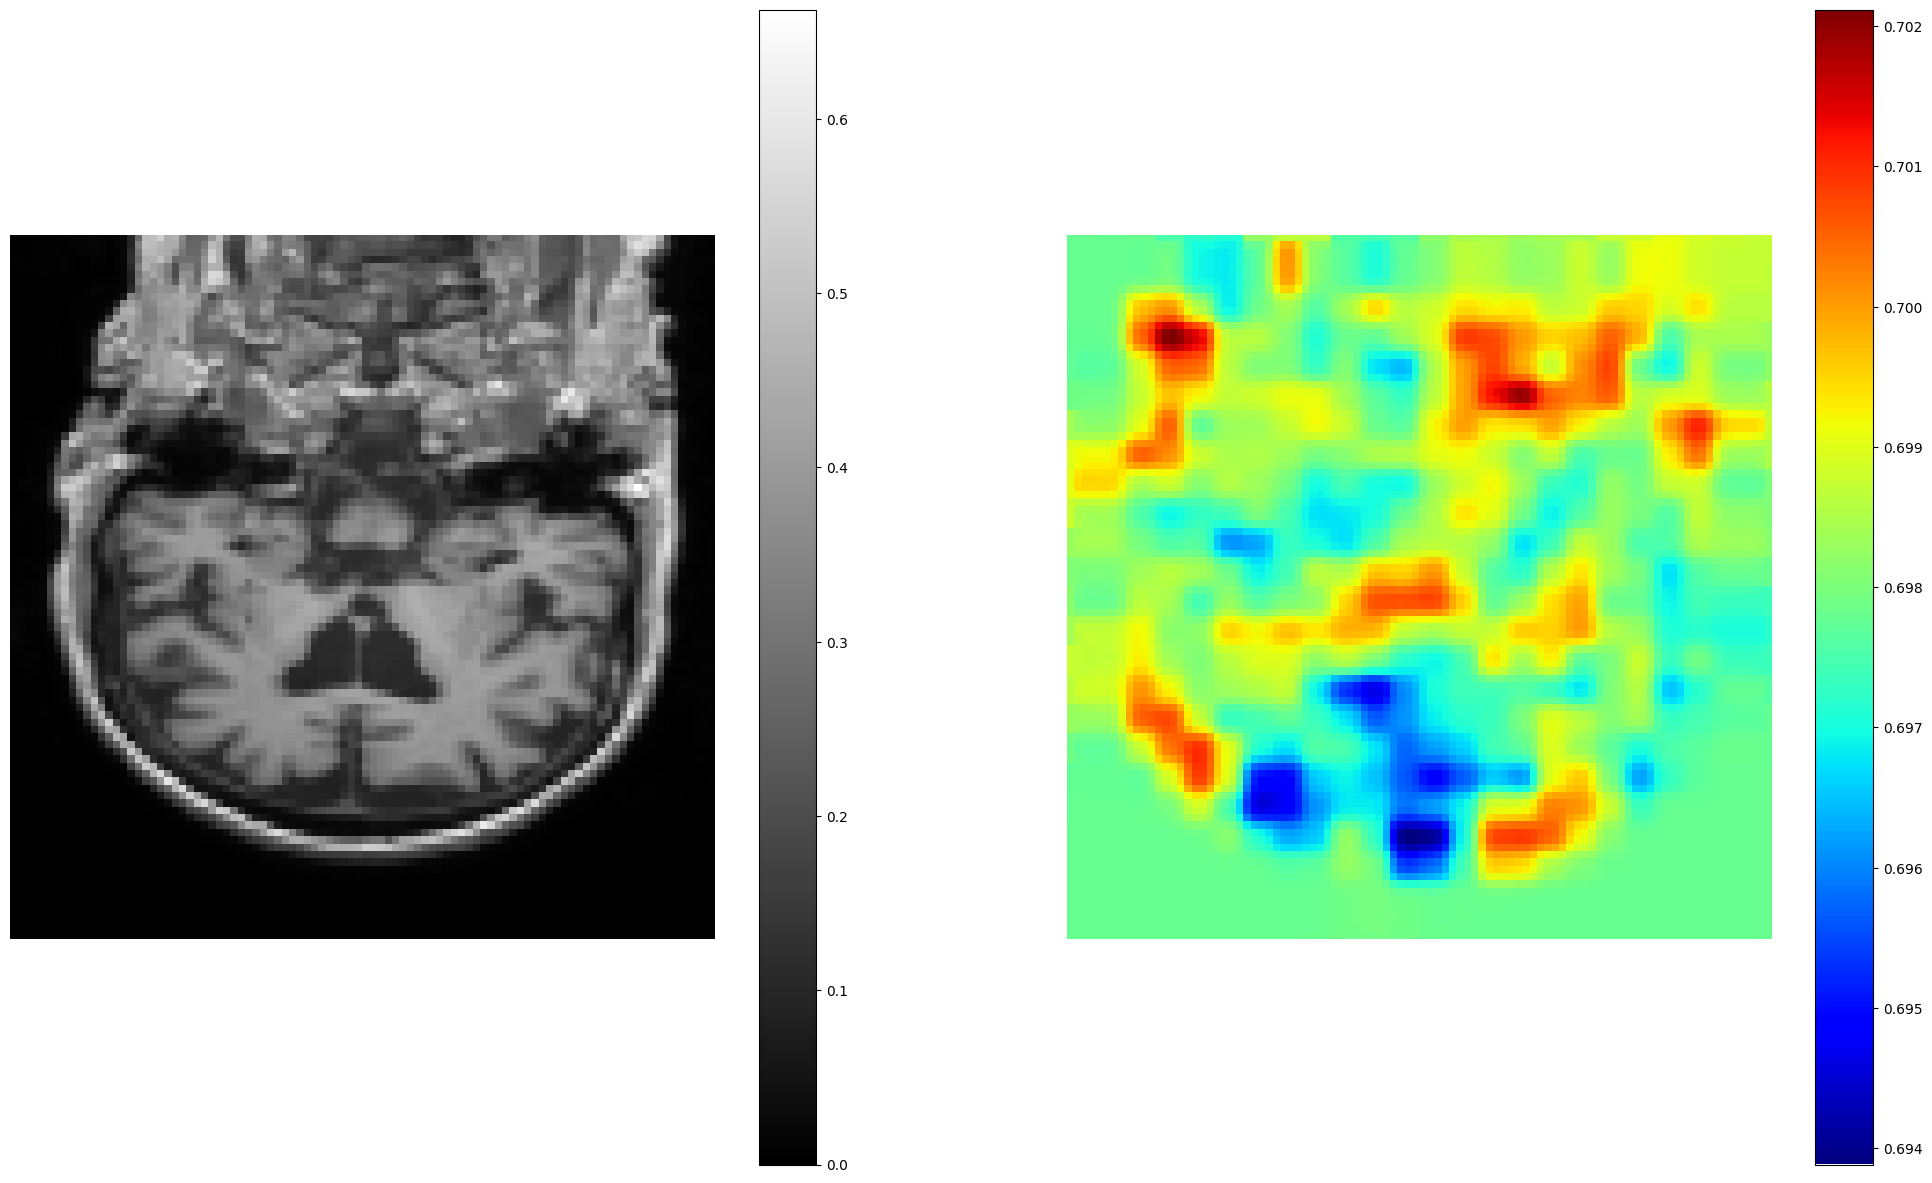

In [53]:
occ_map = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=10) #, stride=12)
depth_slice = image_.shape[2] // 2
occ_bbox = [depth_slice -1, depth_slice, -1, -1, -1, -1]
occ_result, _ = occ_map(x=image_, b_box=occ_bbox)
occ_result = occ_result[0, label.argmax().item()][None]
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, image in enumerate([image_[:, :, depth_slice, ], occ_result]):
  cmap = 'gray' if i == 0 else 'jet'
  ax = axes[i]
  im_show = ax.imshow(np.squeeze(image[0][0].detach().cpu()), cmap=cmap)
  ax.axis('off')
  fig.colorbar(im_show, ax=ax)